This notebook contains the inference and also ensemble of the models based on majority voting

The tests are made based on validation set in order to see the success of the ensemble model.

In [1]:
# Load libraries
import torch
from tqdm import tqdm
import pickle as pk
import numpy as np
import scipy.stats
import os
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

import os
import sys; sys.path.insert(0, os.path.abspath("../../"))
import cv2
import numpy as np
import pandas as pdc
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import time
import copy
import timm
from prettytable import PrettyTable

import logging
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score

## paths
this_path = Path().resolve()
binary_data = this_path.parent.parent/'data_processed/binary/'
three_class_data = this_path.parent.parent/'data_processed/three_class/'
models_path_binary = this_path.parent.parent/'models/binary/'
models_path_multiclass = this_path.parent.parent/'models/three_class/'

# device setting 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Binary Problem

In [2]:
cfg = {
    'data': {
        'data_dir' : binary_data,
        'tensorboard_path' : models_path_binary/'tensorboard/',
        },
    'train': {
        'epochs' : 70,
        'batch_size' : 25,
        'lr' : 0.0001, # deafult:0.0001
        'momentum' : 0.9,
        'weight_decay' : 0.00005,
        'num_workers' : 2,
        'lr_step_size' : 5,
        'gamma' : 0.1,
        'sch_patience': 7,
        'sch_thresh': 0.01,
        'es_patience': 15,
        'es_delta': 0.02,
        'cuda': 'cuda:0',
        },

    'val': {
        'batch_size' : 25,
        'num_workers' : 2,
        },
        
    'test': {
        'batch_size' : 10,
        'num_workers' : 2,
        },
}

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation((0, 70), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.RandomEqualize(),
        # transforms.RandomAffine(degrees=(-30,30), translate=(0.1, 0.2), scale=(0.95, 1.2)),
        transforms.ColorJitter(brightness=0.1, hue=0.1),
        transforms.GaussianBlur(kernel_size=(3,9)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

datasets = {x: datasets.ImageFolder(os.path.join(cfg['data']['data_dir'], x), transform=data_transforms[x])
            for x in ['train', 'val', 'test']}
            
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val', 'test']}

class_names = datasets['train'].classes

device = torch.device(cfg['train']['cuda'] if torch.cuda.is_available() else "cpu") # "cpu"


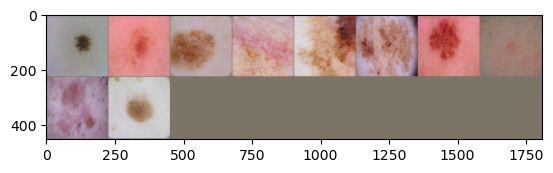

In [4]:
dataloaders = {
        'val': DataLoader(
            datasets['val'], batch_size=cfg['val']['batch_size'],
            num_workers=cfg['val']['num_workers'], drop_last=True),
        'train': DataLoader(
            datasets['train'], batch_size=cfg['train']['batch_size'],
            shuffle=True, num_workers=cfg['val']['num_workers'], drop_last=True),
        'test': DataLoader(
            datasets['test'], batch_size=cfg['test']['batch_size'],
            shuffle=False, num_workers=cfg['test']['num_workers'], drop_last=False)
    }

#show the validation images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=None)

In [5]:
# load the models to be ensenbled

def load_model(model_path, model_name, num_classes):
    if model_name=='swin_t':
        loaded_model = models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1)
        num_ftrs = loaded_model.head.in_features
        loaded_model.head = nn.Linear(num_ftrs, num_classes)

    if model_name=='densenet121':
        loaded_model = models.densenet121(weights='DEFAULT')
        num_ftrs = loaded_model.classifier.in_features
        loaded_model.classifier = nn.Linear(num_ftrs, num_classes)

    if model_name=='regnet':
        loaded_model = models.regnet_y_800mf(weights=models.RegNet_Y_800MF_Weights.DEFAULT)
        num_ftrs = loaded_model.fc.in_features
        loaded_model.fc = nn.Linear(num_ftrs, num_classes)
    
    
    checkpoint = torch.load(model_path)
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    loaded_model.to(device)

    return loaded_model

In [6]:
# Binary classification - Soft voting - Final model for testing!!!

model_path1 = models_path_binary/"swin_t"/"exp15-4"/"best_model.pt"
model1 = load_model(model_path1, 'swin_t', 2)

model_path2 = models_path_binary/"densenet121"/'exp6'/'best_model.pt'
model2 = load_model(model_path2, 'densenet121', 2)

model_path3 = models_path_binary/"regnet"/'exp1'/'best_model.pt'
model3 = load_model(model_path3, 'regnet', 2)

# Set the models to eval mode (optional, but recommended)
model1.eval()
model2.eval()
model3.eval()

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=4, bias=False)
            

In [9]:
# Define a function to get the predictions from a single model
def get_probablities(model, data):
  # Run the model on the data
  logits = model(data)
  probs = torch.softmax(logits, dim=1)
  return probs


save_preds = []
# Iterate over the data
for data, labels in dataloaders['test']:
  # Get the predictions from each model
  data = data.to(device)
  # labels = labels.to(device)

  probs1 = get_probablities(model1, data)
  probs2 = get_probablities(model2, data)
  probs3 = get_probablities(model3, data)

  # Take the average of the predictions
  probs = (probs1 + probs2 + probs3) / 3

  # Get the class with the highest probability
  preds = probs.argmax(dim=1)

  preds = preds.cpu().numpy()
  # labels = labels.cpu().numpy()

  save_preds.extend(preds)

  """
  print(f"predictions1: {probs1}" )
  print(f"predictions2: {probs2}" )
  print(f"predictions3: {probs3}" )
  print(f"probs: {probs}" )
  print(f"output: {preds}" )"""

# save the predictions
# np.savetxt(binary_data/"predictions.csv", save_preds, delimiter='\t')

In [14]:
pdc.DataFrame(save_preds).to_csv(binary_data/'bin_test_preds.csv', index=False, header=False)

In [20]:
colab_res = pdc.read_csv(binary_data/'predictions.csv', header=None)
colab_res = colab_res[0].values
server_res = pdc.read_csv(binary_data/'bin_test_preds.csv', header=None)
server_res = server_res[0].values
print((colab_res == server_res).sum())
print(np.unique(server_res, return_counts=True))

6340
(array([0, 1]), array([3346, 2994]))


In [21]:
vlad_res = pdc.read_csv(binary_data/'vlad.csv')
vlad_res = vlad_res['pred'].values
print(np.unique(vlad_res, return_counts=True))

(array([0, 1]), array([3255, 3085]))


In [22]:
print(cohen_kappa_score(server_res, vlad_res))

0.8625714325578985


In [65]:
# Binary classification 

model_path1 = models_path_binary/"swin_t"/'exp15-4'/'best_model.pt'
model1 = load_model(model_path1, 'swin_t', 2)

model_path2 = models_path_binary/"densenet121"/'exp6'/'best_model.pt'
model2 = load_model(model_path2, 'densenet121', 2)

model_path3 = models_path_binary/"regnet"/'exp1'/'best_model.pt'
model3 = load_model(model_path3, 'regnet', 2)

# Set the models to eval mode (optional, but recommended)
model1.eval()
model2.eval()
model3.eval()

# Define a function to get the predictions from a single model
def get_predictions(model, data):
  # Run the model on the data
  logits = model(data)
  # Get the class with the highest probability for each sample
  _, predicted_classes = logits.max(dim=1)
  predicted_classes = predicted_classes.to(torch.int64)
  return predicted_classes


total_acc = 0 
total = 0 
num_of_batches = 0
# Iterate over the data
for data, labels in dataloaders['val']:
  # Get the predictions from each model
  data = data.to(device)
  labels = labels.to(device)

  predictions1 = get_predictions(model1, data)
  predictions2 = get_predictions(model2, data)
  predictions3 = get_predictions(model3, data)

  stack = torch.stack([predictions1, predictions2, predictions3])

  # convert to numpy
  stack = stack.cpu().numpy()
  labels = labels.cpu().numpy()

  # Get the majority class for each sample
  ensemble_output = scipy.stats.mode(stack, axis=0).mode[0]

  # print(f"predictions1: {predictions1}" )
  # print(f"predictions2: {predictions2}" )
  # print(f"predictions3: {predictions3}" )
  # print(f"output: {ensemble_output}" )

  # Evaluation of Ensemble Model
  total += len(labels) # total number of val images = 3775 (151 batches * 25 images per batch)

  running_accuracy = accuracy_score(labels, ensemble_output)
  total_acc += running_accuracy
  num_of_batches += 1 # number of batches is determined based on the epoch size (if epoch size is 25, then num_of_batches = 151 for 3775 val images)

# takes the average of the accuracy of each batch
print('Accuracy of the model based on the val set of inputs is: %d %%' % (100 * total_acc / num_of_batches)) 


Accuracy of the model based on the val set of inputs is: 91 %


# Three class problem

In [1]:
import os
import sys; sys.path.insert(0, os.path.abspath("../../"))
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import time
import copy
import timm
from prettytable import PrettyTable

import logging
import torch
import torchvision

import pickle as pk

import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, WeightedRandomSampler
from torcheval.metrics.functional import multiclass_confusion_matrix
from torchvision import datasets, models, transforms
from collections import Counter
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
import kornia.losses as losses
import scipy.stats
from torch.utils.tensorboard import SummaryWriter
this_path = Path().resolve()
binary_data = this_path.parent.parent/'data_processed/binary/'
three_class_data = this_path.parent.parent/'data_processed/three_class/'
models_path_binary = this_path.parent.parent/'models/binary/'
models_path_multiclass = this_path.parent.parent/'models/three_class/'

# device setting 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
cfg = {
    'data': {
        'data_dir' : three_class_data,
        },
    'train': {
        'epochs' : 70,
        'batch_size' : 25,
        'lr' : 0.0001, # deafult:0.0001
        'momentum' : 0.9,
        'weight_decay' : 0.00005,
        'num_workers' : 2,
        'lr_step_size' : 5,
        'gamma' : 0.1,
        'milestones': [23, 40, 50],
        'sch_patience': 7,
        'sch_thresh': 0.001,
        'es_patience': 5,
        'es_delta': 0.02,
        'cuda': 'cuda:0',
        'loss': 'focal',
        'weight_criterion': False,
        'sampler': False,
        'optimizer': 'adam'
        },
    'val': {
        'batch_size' : 10,
        'num_workers' : 2,
        },
    'test': {
        'batch_size' : 10,
        'num_workers' : 2,
        }
}

In [3]:
data_transforms_new = {
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.6984, 0.5750, 0.5661], [0.1403, 0.1555, 0.1735])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.6984, 0.5750, 0.5661], [0.1403, 0.1555, 0.1735])
    ]),
}

data_transforms_old = {
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


datasets_new = {x: datasets.ImageFolder(os.path.join(cfg['data']['data_dir'], x), transform=data_transforms_new[x])
            for x in ['val', 'test']}
datasets_old = {x: datasets.ImageFolder(os.path.join(cfg['data']['data_dir'], x), transform=data_transforms_old[x])
                for x in ['val', 'test']}
            
dataset_sizes = {x: len(datasets_new[x]) for x in ['test', 'val']}
print(f'Sizes: {dataset_sizes}')

class_names = datasets_new['val'].classes

device = torch.device(cfg['train']['cuda'] if torch.cuda.is_available() else "cpu") # "cpu"

Sizes: {'test': 2121, 'val': 1270}


In [4]:
dataloaders_new = {
        'val': DataLoader(
            datasets_new['val'], batch_size=cfg['val']['batch_size'],
            num_workers=cfg['val']['num_workers'], drop_last=False, shuffle=False),
        'test': DataLoader(
            datasets_new['test'], batch_size=cfg['test']['batch_size'],
            shuffle=False, num_workers=cfg['test']['num_workers'], drop_last=False)
}
dataloaders_old = {
        'val': DataLoader(
            datasets_old['val'], batch_size=cfg['val']['batch_size'],
            num_workers=cfg['val']['num_workers'], drop_last=False, shuffle=False), 
        'test': DataLoader(
            datasets_old['test'], batch_size=cfg['test']['batch_size'],
            shuffle=False, num_workers=cfg['test']['num_workers'], drop_last=False)
}


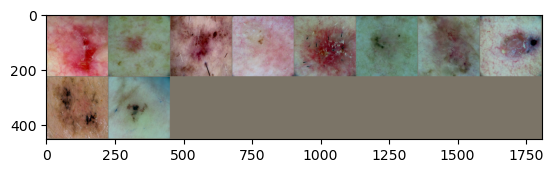

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders_new['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=None)
print(classes)

In [7]:
# load the models to be ensenbled

def load_model(model_path, model_name, num_classes):
    if model_name=='swin_t':
        loaded_model = models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1)
        num_ftrs = loaded_model.head.in_features
        loaded_model.head = nn.Linear(num_ftrs, num_classes)

    if model_name=='densenet121':
        loaded_model = models.densenet121(weights='DEFAULT')
        num_ftrs = loaded_model.classifier.in_features
        loaded_model.classifier = nn.Linear(num_ftrs, num_classes)

    if model_name=='regnet':
        loaded_model = models.regnet_y_800mf(weights=models.RegNet_Y_800MF_Weights.DEFAULT)
        num_ftrs = loaded_model.fc.in_features
        loaded_model.fc = nn.Linear(num_ftrs, num_classes)
    
    
    checkpoint = torch.load(model_path, map_location='cuda:0')
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    loaded_model.to(device)

    return loaded_model

def load_changed_model(model_path3):
  loaded_model = models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1)
  num_ftrs = loaded_model.head.in_features
  # loaded_model.head = nn.Linear(num_ftrs, num_classes)
  loaded_model.head = nn.Sequential(
                          nn.Linear(num_ftrs, 512),
                          nn.ReLU(),
                          nn.Linear(512, 256),
                          nn.ReLU(),
                          nn.Linear(256, 3))
  checkpoint = torch.load(model_path3, map_location='cuda:0')
  loaded_model.load_state_dict(checkpoint['model_state_dict'])
  loaded_model.to(device)
  return loaded_model

In [8]:
# Cohens Kappa gives NaN if all predictions are the same (actually it should be 1)
def kappa(y_test, y_pred):

    if len(set(y_test).union(y_pred)) == 1:
        kappa = 1
    else:
        kappa = cohen_kappa_score(y1=y_test, y2=y_pred)
    return kappa

In [10]:
# Three-class problem - Majority Voting
model_path1 = models_path_multiclass / "swin_t/exp1/best_model.pt"
model1 = load_model(model_path1, 'swin_t', 3)

model_path2 = models_path_multiclass / "swin_t/exp9/best_model.pt"
model2 = load_changed_model(model_path2)

model_path3 = models_path_multiclass /"swin_t/exp13/best_model.pt"
model3 = load_changed_model(model_path3)

# model_path4 = models_path_multiclass+"regnet"+'/exp4'+'/best_model.pt'
# model4 = load_model(model_path4, 'regnet', 3)


# Set the models to eval mode (optional, but recommended)
model1.eval()
model2.eval()
model3.eval()
# model4.eval()

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock(
       

In [27]:
# Define a function to get the predictions from a single model
def get_predictions(model, data):
  # Run the model on the data
  logits = model(data)
  # Get the class with the highest probability for each sample
  _, predicted_classes = logits.max(dim=1)
  predicted_classes = predicted_classes.to(torch.int64)
  return predicted_classes

labels_all = []
preds_model2 = []
preds_model3 = []

# Iterate over the data
for data, labels in dataloaders_new['val']:
  # Get the predictions from each model
  data = data.to(device)
  labels = labels.to(device)

  predictions2 = get_predictions(model2, data)
  predictions3 = get_predictions(model3, data)

  #stack = torch.stack([predictions1, predictions2, predictions3])
  # stack = torch.stack([predictions1, predictions2, predictions3, predictions4])

  # print(f"predictions1: {predictions1}" )
  # print(f"predictions2: {predictions2}" )
  # print(f"predictions3: {predictions3}" )
  # print(f"output: {ensemble_output}" )

  labels_all.extend(labels.cpu().numpy())
  preds_model2.extend(predictions2.cpu().numpy())
  preds_model3.extend(predictions3.cpu().numpy())
  # preds_all.extend(ensemble_output)

print('model 2 and 3 done')
preds_model1 = []
for data, labels in dataloaders_old['val']:
  # Get the predictions from each model
  data = data.to(device)
  labels = labels.to(device)

  predictions1 = get_predictions(model1, data)

  # labels_all.extend(labels)
  preds_model1.extend(predictions1.cpu().numpy())

# stack = torch.stack([preds_model1, preds_model2, preds_model3])
stack = np.stack((np.asarray(preds_model1), np.asarray(preds_model2), np.asarray(preds_model3)))

# # convert to numpy
# stack = stack.cpu().numpy()

# Get the majority class for each sample
ensemble_output = scipy.stats.mode(stack, axis=0).mode[0]

running_kappa = cohen_kappa_score(labels_all, ensemble_output)
print(f"kappa: {running_kappa}")


model 2 and 3 done
kappa: 0.9277533373786407


In [28]:
ensemble_output

array([0, 0, 0, ..., 2, 2, 0])

In [16]:
# test

def get_predictions(model, data):
  # Run the model on the data
  logits = model(data)
  # Get the class with the highest probability for each sample
  _, predicted_classes = logits.max(dim=1)
  predicted_classes = predicted_classes.to(torch.int64)
  return predicted_classes

labels_all = []
preds_model2 = []
preds_model3 = []

# Iterate over the data
for data, labels in dataloaders_new['test']:
  # Get the predictions from each model
  data = data.to(device)

  predictions2 = get_predictions(model2, data)
  predictions3 = get_predictions(model3, data)

  #stack = torch.stack([predictions1, predictions2, predictions3])
  # stack = torch.stack([predictions1, predictions2, predictions3, predictions4])

  # print(f"predictions1: {predictions1}" )
  # print(f"predictions2: {predictions2}" )
  # print(f"predictions3: {predictions3}" )
  # print(f"output: {ensemble_output}" )

#   labels_all.extend(labels.cpu().numpy())
  preds_model2.extend(predictions2.cpu().numpy())
  preds_model3.extend(predictions3.cpu().numpy())
  # preds_all.extend(ensemble_output)

print('model 2 and 3 done')
preds_model1 = []
for data, labels in dataloaders_old['test']:
  # Get the predictions from each model
  data = data.to(device)

  predictions1 = get_predictions(model1, data)

  preds_model1.extend(predictions1.cpu().numpy())

# stack = torch.stack([preds_model1, preds_model2, preds_model3])
stack = np.stack((np.asarray(preds_model1), np.asarray(preds_model2), np.asarray(preds_model3)))

# # convert to numpy
# stack = stack.cpu().numpy()

# Get the majority class for each sample
ensemble_output = scipy.stats.mode(stack, axis=0).mode[0]


model 2 and 3 done


In [19]:
pd.DataFrame(ensemble_output).to_csv(three_class_data/'3c_test_preds.csv', index=False, header=False)

In [6]:
server_res = pd.read_csv(three_class_data/'3c_test_preds.csv', header=None)
server_res.replace({1:0, 0:1}, inplace=True)
server_res.to_csv(three_class_data/'3c_test_preds_corrected.csv', index=False, header=False)
server_res = server_res.values
print(np.unique(server_res, return_counts=True))

(array([0, 1, 2]), array([1135,  848,  138]))


In [23]:
vlad_res = pd.read_csv(three_class_data/'vlad.csv')
vlad_res = vlad_res['pred_corrected'].values
print(np.unique(vlad_res, return_counts=True))

(array([0, 1, 2]), array([1127,  834,  160]))


In [26]:
print(cohen_kappa_score(server_res, vlad_res))

0.9207877811438834
